## Задание 5.1

Набор данных тут: https://github.com/sismetanin/rureviews, также есть в папке [Data](https://drive.google.com/drive/folders/1YAMe7MiTxA-RSSd8Ex2p-L0Dspe6Gs4L). Те, кто предпочитает работать с английским языком, могут использовать набор данных `sms_spam`.

Применим полученные навыки и решим задачу анализа тональности отзывов. 

Нужно повторить весь пайплайн от сырых текстов до получения обученной модели.

Обязательные шаги предобработки:
1. приведение к нижнему регистру
2. токенизация
3. удаление стоп-слов
4. лемматизация
5. векторизация (с настройкой гиперпараметров)
6. построение модели
7. оценка качества модели

Обязательно использование векторайзеров:
1. мешок n-грамм (диапазон для n подбирайте самостоятельно, запрещено использовать только униграммы).
2. tf-idf ((диапазон для n подбирайте самостоятельно, также нужно подбирать гиперпараметры max_df, min_df, max_features)
3. символьные n-граммы (диапазон для n подбирайте самостоятельно)

В качестве классификатора нужно использовать наивный байесовский классификатор. 

Для сравнения векторайзеров между собой используйте precision, recall, f1-score и accuracy. Для этого сформируйте датафрейм, в котором в строках будут разные векторайзеры, а в столбцах разные метрики качества, а в  ячейках будут значения этих метрик для соответсвующих векторайзеров.

### 0) Загрузка и подготовка данных

In [40]:
import nltk
import pandas as pd
import string
import numpy as np
import warnings
import matplotlib.pyplot as plt

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.naive_bayes import MultinomialNB


warnings.filterwarnings('ignore')
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
pd.set_option('max_colwidth', 400)
%matplotlib inline

In [ ]:
from google.colab import drive


drive.mount("/google_drive")

Mounted at /google_drive


In [56]:
sms_spam = pd.read_csv("/google_drive/MyDrive/Data/sms_spam.csv", sep=",")
sms_spam

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 cash needs your URGENT collection. 09066364349 NOW from Landline not to lose out! Box434SK38WP150PPM18+"
4,spam,okmail: Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm
...,...,...
5554,ham,You are a great role model. You are giving so much and i really wish each day for a miracle but God as a reason for everything and i must say i wish i knew why but i dont. I've looked up to you since i was young and i still do. Have a great day.
5555,ham,"Awesome, I remember the last time we got somebody high for the first time with diesel :V"
5556,spam,"If you don't, your prize will go to another customer. T&C at www.t-c.biz 18+ 150p/min Polo Ltd Suite 373 London W1J 6HL Please call back if busy"
5557,spam,"SMS. ac JSco: Energy is high, but u may not know where 2channel it. 2day ur leadership skills r strong. Psychic? Reply ANS w/question. End? Reply END JSCO"


#### 1. Изменим type на ±1

In [57]:
sms_spam.replace({"type": {"ham": -1, "spam": 1}}, inplace=True)
sms_spam

,type,text
0,-1,Hope you are having a good week. Just checking in
1,-1,K..give back my thanks.
2,-1,Am also doing in cbe only. But have to pay.
3,1,"complimentary 4 STAR Ibiza Holiday or £10,000 cash needs your URGENT collection. 09066364349 NOW from Landline not to lose out! Box434SK38WP150PPM18+"
4,1,okmail: Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm
...,...,...
5554,-1,You are a great role model. You are giving so much and i really wish each day for a miracle but God as a reason for everything and i must say i wish i knew why but i dont. I've looked up to you since i was young and i still do. Have a great day.
5555,-1,"Awesome, I remember the last time we got somebody high for the first time with diesel :V"
5556,1,"If you don't, your prize will go to another customer. T&C at www.t-c.biz 18+ 150p/min Polo Ltd Suite 373 London W1J 6HL Please call back if busy"
5557,1,"SMS. ac JSco: Energy is high, but u may not know where 2channel it. 2day ur leadership skills r strong. Psychic? Reply ANS w/question. End? Reply END JSCO"


#### 2. Уберём знаки препинания

In [58]:
sms_spam.text = sms_spam.text.str.replace(rf"[{string.punctuation}]", "", regex=True) 
sms_spam

,type,text
0,-1,Hope you are having a good week Just checking in
1,-1,Kgive back my thanks
2,-1,Am also doing in cbe only But have to pay
3,1,complimentary 4 STAR Ibiza Holiday or £10000 cash needs your URGENT collection 09066364349 NOW from Landline not to lose out Box434SK38WP150PPM18
4,1,okmail Dear Dave this is your final notice to collect your 4 Tenerife Holiday or 5000 CASH award Call 09061743806 from landline TCs SAE Box326 CW25WX 150ppm
...,...,...
5554,-1,You are a great role model You are giving so much and i really wish each day for a miracle but God as a reason for everything and i must say i wish i knew why but i dont Ive looked up to you since i was young and i still do Have a great day
5555,-1,Awesome I remember the last time we got somebody high for the first time with diesel V
5556,1,If you dont your prize will go to another customer TC at wwwtcbiz 18 150pmin Polo Ltd Suite 373 London W1J 6HL Please call back if busy
5557,1,SMS ac JSco Energy is high but u may not know where 2channel it 2day ur leadership skills r strong Psychic Reply ANS wquestion End Reply END JSCO


### 1) Приведение к нижнему регистру

In [59]:
sms_spam.text = sms_spam.text.str.lower()
sms_spam

,type,text
0,-1,hope you are having a good week just checking in
1,-1,kgive back my thanks
2,-1,am also doing in cbe only but have to pay
3,1,complimentary 4 star ibiza holiday or £10000 cash needs your urgent collection 09066364349 now from landline not to lose out box434sk38wp150ppm18
4,1,okmail dear dave this is your final notice to collect your 4 tenerife holiday or 5000 cash award call 09061743806 from landline tcs sae box326 cw25wx 150ppm
...,...,...
5554,-1,you are a great role model you are giving so much and i really wish each day for a miracle but god as a reason for everything and i must say i wish i knew why but i dont ive looked up to you since i was young and i still do have a great day
5555,-1,awesome i remember the last time we got somebody high for the first time with diesel v
5556,1,if you dont your prize will go to another customer tc at wwwtcbiz 18 150pmin polo ltd suite 373 london w1j 6hl please call back if busy
5557,1,sms ac jsco energy is high but u may not know where 2channel it 2day ur leadership skills r strong psychic reply ans wquestion end reply end jsco


### 2) Удаление стоп-слов

In [60]:
noise = stopwords.words("english")
print(*noise[:10])

sms_spam.text = sms_spam.text.apply(lambda x: " ".join([word for word in x.split() if word not in noise]))
sms_spam

i me my myself we our ours ourselves you you're


,type,text
0,-1,hope good week checking
1,-1,kgive back thanks
2,-1,also cbe pay
3,1,complimentary 4 star ibiza holiday £10000 cash needs urgent collection 09066364349 landline lose box434sk38wp150ppm18
4,1,okmail dear dave final notice collect 4 tenerife holiday 5000 cash award call 09061743806 landline tcs sae box326 cw25wx 150ppm
...,...,...
5554,-1,great role model giving much really wish day miracle god reason everything must say wish knew dont ive looked since young still great day
5555,-1,awesome remember last time got somebody high first time diesel v
5556,1,dont prize go another customer tc wwwtcbiz 18 150pmin polo ltd suite 373 london w1j 6hl please call back busy
5557,1,sms ac jsco energy high u may know 2channel 2day ur leadership skills r strong psychic reply ans wquestion end reply end jsco


### 3) Токенизация

In [61]:
sms_spam.text = sms_spam.text.apply(word_tokenize)
sms_spam

,type,text
0,-1,"[hope, good, week, checking]"
1,-1,"[kgive, back, thanks]"
2,-1,"[also, cbe, pay]"
3,1,"[complimentary, 4, star, ibiza, holiday, £10000, cash, needs, urgent, collection, 09066364349, landline, lose, box434sk38wp150ppm18]"
4,1,"[okmail, dear, dave, final, notice, collect, 4, tenerife, holiday, 5000, cash, award, call, 09061743806, landline, tcs, sae, box326, cw25wx, 150ppm]"
...,...,...
5554,-1,"[great, role, model, giving, much, really, wish, day, miracle, god, reason, everything, must, say, wish, knew, dont, ive, looked, since, young, still, great, day]"
5555,-1,"[awesome, remember, last, time, got, somebody, high, first, time, diesel, v]"
5556,1,"[dont, prize, go, another, customer, tc, wwwtcbiz, 18, 150pmin, polo, ltd, suite, 373, london, w1j, 6hl, please, call, back, busy]"
5557,1,"[sms, ac, jsco, energy, high, u, may, know, 2channel, 2day, ur, leadership, skills, r, strong, psychic, reply, ans, wquestion, end, reply, end, jsco]"


### 4) Лемматизация

In [62]:
def get_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

sms_spam.text = sms_spam.text.apply(lambda x: " ".join([lemmatizer.lemmatize(word, get_pos(word)) for word in x]))
sms_spam

,type,text
0,-1,hope good week check
1,-1,kgive back thanks
2,-1,also cbe pay
3,1,complimentary 4 star ibiza holiday £10000 cash need urgent collection 09066364349 landline lose box434sk38wp150ppm18
4,1,okmail dear dave final notice collect 4 tenerife holiday 5000 cash award call 09061743806 landline tc sae box326 cw25wx 150ppm
...,...,...
5554,-1,great role model give much really wish day miracle god reason everything must say wish knew dont ive look since young still great day
5555,-1,awesome remember last time get somebody high first time diesel v
5556,1,dont prize go another customer tc wwwtcbiz 18 150pmin polo ltd suite 373 london w1j 6hl please call back busy
5557,1,sm ac jsco energy high u may know 2channel 2day ur leadership skill r strong psychic reply an wquestion end reply end jsco


### 5-7) Векторизация, Построение модели, Оценка Точности

In [63]:
sms_spam_prepared = sms_spam.copy(deep=True)
x_train, x_test, y_train, y_test = train_test_split(sms_spam_prepared.text,
                                                        sms_spam_prepared.type,
                                                        train_size=0.7)

# Создание модели Наивного Байесовского Классификатора
model = MultinomialNB()
types_dict = {"name": str, "accuracy": float, "precision": float, "recall": float, "f1": float}
COLUMNS_AMOUNT = 5

#### 1. Мешок слов (n-грамм)

In [64]:
ngram_max_size = 6

ngram_ranges = [(i, j) for i in range(1, ngram_max_size) for j in range(i, ngram_max_size)]
result_ngram = np.empty((0, COLUMNS_AMOUNT))
for ngram_range in ngram_ranges:
    ngram_vectorizer = CountVectorizer(ngram_range=ngram_range)
    x_train_ngram = ngram_vectorizer.fit_transform(x_train)
    x_test_ngram = ngram_vectorizer.transform(x_test)
    v_name = f"{ngram_vectorizer.__class__.__name__} {ngram_range[0]}-{ngram_range[1]}"

    # Обучение
    model.fit(x_train_ngram, y_train)

    # Тестирование
    y_pred_ngram = model.predict(x_test_ngram)
    accuracy_ngram = accuracy_score(y_test, y_pred_ngram)
    precision_ngram = precision_score(y_test, y_pred_ngram)
    recall_ngram = recall_score(y_test, y_pred_ngram)
    f1_ngram = f1_score(y_test, y_pred_ngram)
    test_result = np.array([[v_name, accuracy_ngram, precision_ngram, recall_ngram, f1_ngram]])
    result_ngram = np.append(result_ngram, test_result, axis=0)

In [65]:
df_result_ngram = pd.DataFrame(result_ngram, columns=["name", "accuracy", "precision", "recall", "f1"])
df_result_ngram = df_result_ngram.astype(types_dict)
df_result_ngram

,name,accuracy,precision,recall,f1
0,CountVectorizer 1-1,0.982014,0.947619,0.912844,0.929907
1,CountVectorizer 1-2,0.983213,0.965686,0.903670,0.933649
2,CountVectorizer 1-3,0.983813,0.975124,0.899083,0.935561
3,CountVectorizer 1-4,0.983813,0.975124,0.899083,0.935561
4,CountVectorizer 1-5,0.983813,0.975124,0.899083,0.935561
5,CountVectorizer 2-2,0.970624,0.982857,0.788991,0.875318
6,CountVectorizer 2-3,0.970624,0.982857,0.788991,0.875318
7,CountVectorizer 2-4,0.971223,0.988506,0.788991,0.877551
8,CountVectorizer 2-5,0.971223,0.988506,0.788991,0.877551
9,CountVectorizer 3-3,0.953837,1.000000,0.646789,0.785515


Найдём те параметры векторайзера, при которых были получены лучшие показатели оценки качества по каждому из способов:

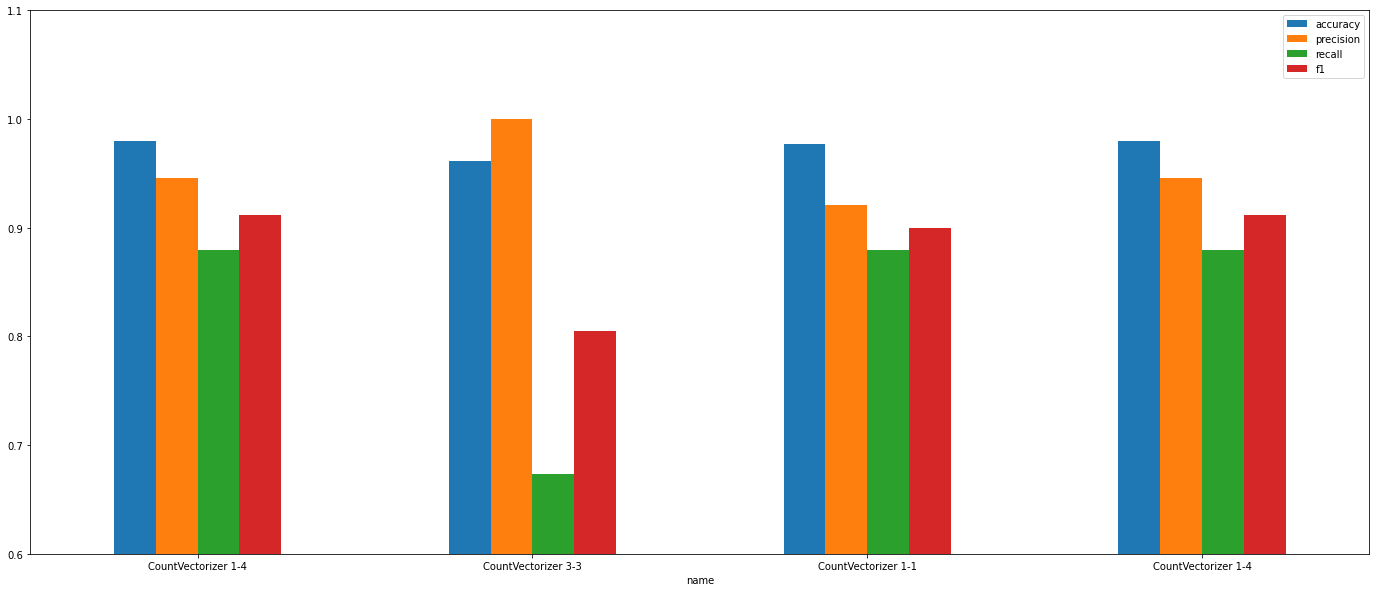

In [ ]:
indexes_ngram = np.array([])
for column in df_result_ngram.columns[1:]:
    indexes_ngram = np.append(indexes_ngram, df_result_ngram[column].idxmax())

df_result_ngram_plot = df_result_ngram.loc[indexes_ngram]
df_result_ngram_plot.set_index("name", inplace=True)
df_result_ngram_plot.plot.bar(rot=0, figsize=(24, 10), ylim=(0.6, 1.1))

#### 2. TF-IDF

In [ ]:
result_tfidf = np.empty((0, COLUMNS_AMOUNT))
tfidf_max_size = 6
tfidf_ranges = [(i, j) for i in range(1, tfidf_max_size) for j in range(i, tfidf_max_size)]  # 15
tfidf_max_df = np.arange(0.5, 1.01, 0.1)  # 6
tfidf_min_df = np.arange(0.0, 0.011, 0.002)  # 5
tfidf_max_features = np.arange(10 ** 3, 10 ** 4 + 1, 10 ** 3)  # 10

for tfidf_range in tfidf_ranges:
    for max_df in tfidf_max_df:
        for min_df in tfidf_min_df:
            for max_features in tfidf_max_features:
                tfidf_vectorizer = TfidfVectorizer(ngram_range=tfidf_range, max_df=max_df, min_df=min_df,
                                                    max_features=max_features)
                try:
                    x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
                except ValueError as ignored:
                    continue

                x_test_tfidf = tfidf_vectorizer.transform(x_test)
                v_name = f"{tfidf_vectorizer.__class__.__name__} {tfidf_range[0]}-{tfidf_range[1]} " \
                            f"max_df={max_df} min_df={min_df} max_features={max_features}"

                # Обучение
                model.fit(x_train_tfidf, y_train)

                # Тестирование
                y_pred_tfidf = model.predict(x_test_tfidf)
                accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
                precision_tfidf = precision_score(y_test, y_pred_tfidf)
                recall_tfidf = recall_score(y_test, y_pred_tfidf)
                f1_tfidf = f1_score(y_test, y_pred_tfidf)
                test_result = np.array([[v_name, accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf]])
                result_tfidf = np.append(result_tfidf, test_result, axis=0)

In [ ]:
df_result_tfidf = pd.DataFrame(result_tfidf, columns=["name", "accuracy", "precision", "recall", "f1"])
df_result_tfidf = df_result_tfidf.astype(types_dict)
df_result_tfidf

,name,accuracy,precision,recall,f1
0,TfidfVectorizer 1-1 max_df=0.5 min_df=0.0 max_features=1000,0.976619,0.954545,0.844221,0.896000
1,TfidfVectorizer 1-1 max_df=0.5 min_df=0.0 max_features=2000,0.977818,0.976471,0.834171,0.899729
2,TfidfVectorizer 1-1 max_df=0.5 min_df=0.0 max_features=3000,0.977818,0.987952,0.824121,0.898630
3,TfidfVectorizer 1-1 max_df=0.5 min_df=0.0 max_features=4000,0.974221,1.000000,0.783920,0.878873
4,TfidfVectorizer 1-1 max_df=0.5 min_df=0.0 max_features=5000,0.971823,1.000000,0.763819,0.866097
...,...,...,...,...,...
4315,TfidfVectorizer 5-5 max_df=0.9999999999999999 min_df=0.002 max_features=6000,0.881295,1.000000,0.005025,0.010000
4316,TfidfVectorizer 5-5 max_df=0.9999999999999999 min_df=0.002 max_features=7000,0.881295,1.000000,0.005025,0.010000
4317,TfidfVectorizer 5-5 max_df=0.9999999999999999 min_df=0.002 max_features=8000,0.881295,1.000000,0.005025,0.010000
4318,TfidfVectorizer 5-5 max_df=0.9999999999999999 min_df=0.002 max_features=9000,0.881295,1.000000,0.005025,0.010000


Найдём те параметры векторайзера, при которых были получены лучшие показатели оценки качества по каждому из способов:

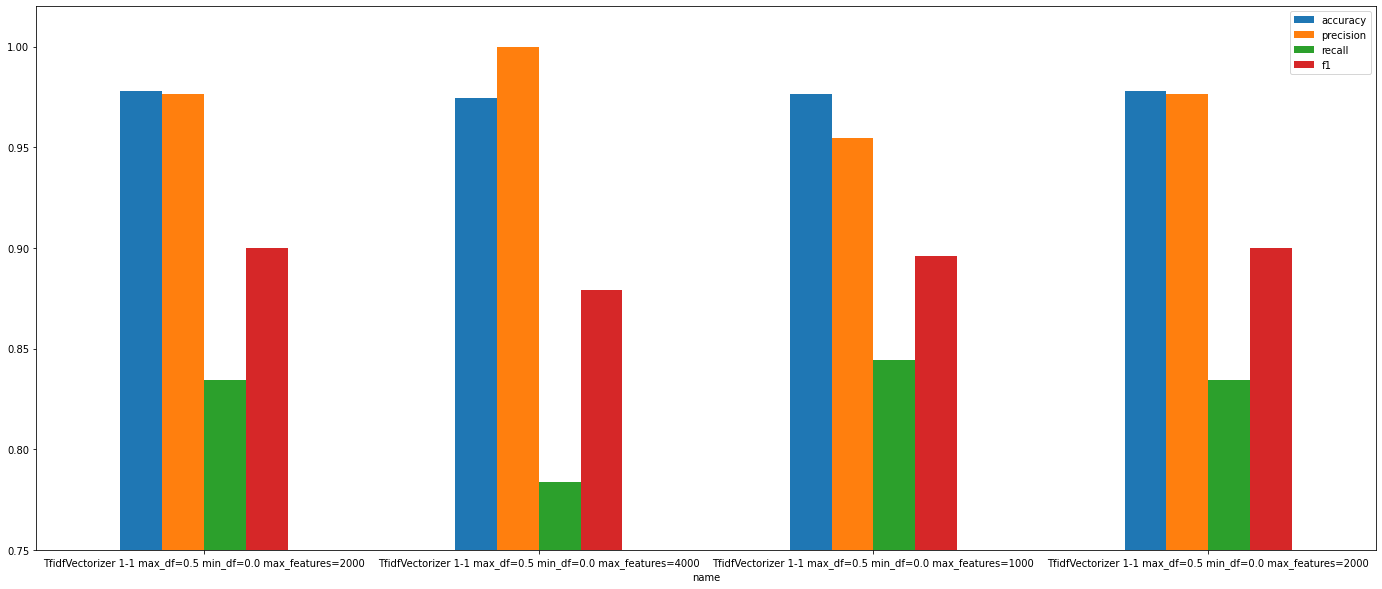

In [ ]:
indexes_tfidf = np.array([])
for column in df_result_tfidf.columns[1:]:
    indexes_tfidf = np.append(indexes_tfidf, df_result_tfidf[column].idxmax())

df_result_tfidf_plot = df_result_tfidf.loc[indexes_tfidf]
df_result_tfidf_plot.set_index("name", inplace=True)
df_result_tfidf_plot.plot.bar(rot=0, figsize=(24, 10), ylim=(0.75, 1.02))

#### 3. Символьные n-граммы

In [ ]:
char_ngram_max_size = 6
char_ngram_ranges = [(i, j) for i in range(1, char_ngram_max_size) for j in range(i, char_ngram_max_size)]
result_char_ngram = np.empty((0, COLUMNS_AMOUNT))
for char_ngram_range in char_ngram_ranges:
    char_ngram_vectorizer = CountVectorizer(analyzer="char", ngram_range=char_ngram_range)
    x_train_char_ngram = char_ngram_vectorizer.fit_transform(x_train)
    x_test_char_ngram = char_ngram_vectorizer.transform(x_test)
    v_name = f"Char{char_ngram_vectorizer.__class__.__name__} {char_ngram_range[0]}-{char_ngram_range[1]}"

    # Обучение
    model.fit(x_train_char_ngram, y_train)

    # Тестирование
    y_pred_char_ngram = model.predict(x_test_char_ngram)
    accuracy_char_ngram = accuracy_score(y_test, y_pred_char_ngram)
    precision_char_ngram = precision_score(y_test, y_pred_char_ngram)
    recall_char_ngram = recall_score(y_test, y_pred_char_ngram)
    f1_char_ngram = f1_score(y_test, y_pred_char_ngram)
    test_result = np.array([[v_name, accuracy_char_ngram, precision_char_ngram, recall_char_ngram, f1_char_ngram]])
    result_char_ngram = np.append(result_char_ngram, test_result, axis=0)

In [ ]:
df_result_char_ngram = pd.DataFrame(result_char_ngram, columns=["name", "accuracy", "precision", "recall", "f1"])
df_result_char_ngram = df_result_char_ngram.astype(types_dict)
df_result_char_ngram

,name,accuracy,precision,recall,f1
0,CharCountVectorizer 1-1,0.973621,0.893401,0.884422,0.888889
1,CharCountVectorizer 1-2,0.977818,0.917526,0.894472,0.905852
2,CharCountVectorizer 1-3,0.980815,0.923858,0.914573,0.919192
3,CharCountVectorizer 1-4,0.980815,0.915423,0.924623,0.920000
4,CharCountVectorizer 1-5,0.979017,0.918367,0.904523,0.911392
5,CharCountVectorizer 2-2,0.980815,0.937173,0.899497,0.917949
6,CharCountVectorizer 2-3,0.979017,0.905941,0.919598,0.912718
7,CharCountVectorizer 2-4,0.979017,0.901961,0.924623,0.913151
8,CharCountVectorizer 2-5,0.975420,0.879808,0.919598,0.899263
9,CharCountVectorizer 3-3,0.980815,0.919598,0.919598,0.919598


Найдём те параметры векторайзера, при которых были получены лучшие показатели оценки качества по каждому из способов:

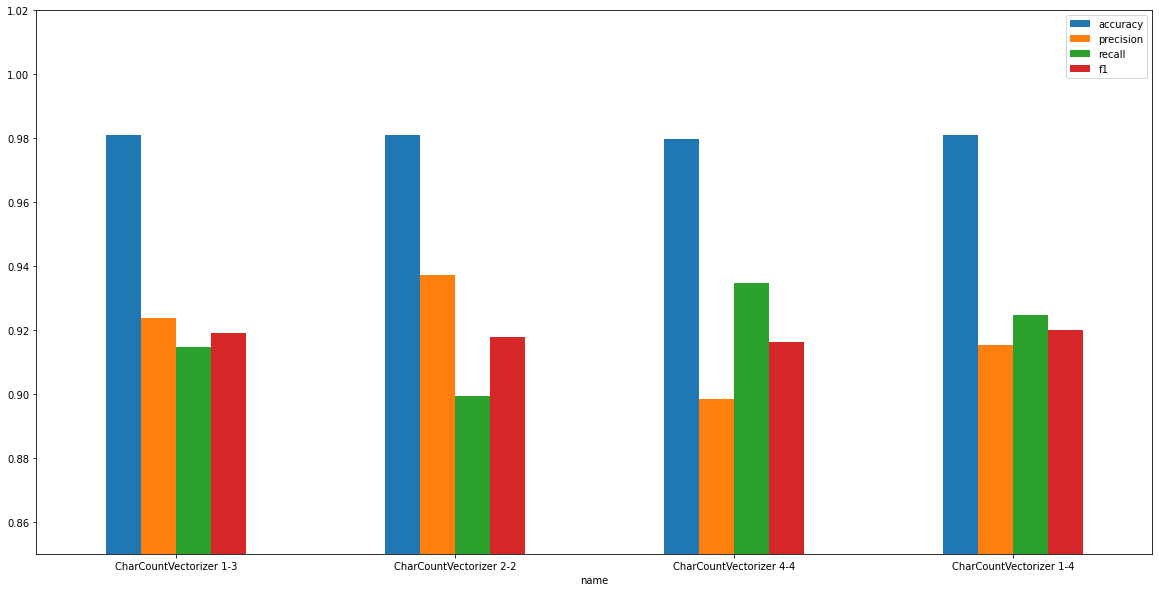

In [ ]:
indexes_char_ngram = np.array([])
for column in df_result_char_ngram.columns[1:]:
    indexes_char_ngram = np.append(indexes_char_ngram, df_result_char_ngram[column].idxmax())

df_result_char_ngram_plot = df_result_char_ngram.loc[indexes_char_ngram]
df_result_char_ngram_plot.set_index("name", inplace=True)
df_result_char_ngram_plot.plot.bar(rot=0, figsize=(20, 10), ylim=(0.85, 1.02))

#### 4. Лучшие векторайзеры

In [ ]:
frames = [df_result_tfidf_plot, df_result_ngram_plot, df_result_char_ngram_plot]
df_result_vectorizers = pd.concat(frames)
df_result_vectorizers

,accuracy,precision,recall,f1
name,,,,
TfidfVectorizer 1-1 max_df=0.5 min_df=0.0 max_features=2000,0.977818,0.976471,0.834171,0.899729
TfidfVectorizer 1-1 max_df=0.5 min_df=0.0 max_features=4000,0.974221,1.000000,0.783920,0.878873
TfidfVectorizer 1-1 max_df=0.5 min_df=0.0 max_features=1000,0.976619,0.954545,0.844221,0.896000
TfidfVectorizer 1-1 max_df=0.5 min_df=0.0 max_features=2000,0.977818,0.976471,0.834171,0.899729
CountVectorizer 1-4,0.979616,0.945946,0.879397,0.911458
CountVectorizer 3-3,0.961031,1.000000,0.673367,0.804805
CountVectorizer 1-1,0.976619,0.921053,0.879397,0.899743
CountVectorizer 1-4,0.979616,0.945946,0.879397,0.911458
CharCountVectorizer 1-3,0.980815,0.923858,0.914573,0.919192


##### Accuracy

In [ ]:
df_result_vectorizers.sort_values(by="accuracy", ascending=False).head(1)

,accuracy,precision,recall,f1
name,,,,
CharCountVectorizer 1-3,0.980815,0.923858,0.914573,0.919192


##### Precision

In [ ]:
df_result_vectorizers.sort_values(by="precision", ascending=False).head(1)

,accuracy,precision,recall,f1
name,,,,
TfidfVectorizer 1-1 max_df=0.5 min_df=0.0 max_features=4000,0.974221,1.0,0.78392,0.878873


##### Recall

In [ ]:
df_result_vectorizers.sort_values(by="recall", ascending=False).head(1)

,accuracy,precision,recall,f1
name,,,,
CharCountVectorizer 4-4,0.979616,0.898551,0.934673,0.916256


##### F1 Score

In [ ]:
df_result_vectorizers.sort_values(by="f1", ascending=False).head(1)

,accuracy,precision,recall,f1
name,,,,
CharCountVectorizer 1-4,0.980815,0.915423,0.924623,0.92


### Вывод:

Самым лучшим векторайзером по показателям F1, Accuracy и Recall является **Char Count Vectorizer** с параметром n_gram равным (1, 4), (1, 3) и (4,4) соответственно. По Precision можно выделить **Count Vectorizer** и **Tfidf Vectorizer**, которые добились показателя 1.0 при n_gram = (3, 3) и n_gram = (1, 1), max_df=0.5, min_df=0.0, max_features=4000 соответственно.

## Задание 5.2 Регулярные выражения

Регулярные выражения - способ поиска и анализа строк. Например, можно понять, какие даты в наборе строк представлены в формате DD/MM/YYYY, а какие - в других форматах. 

Или бывает, например, что перед работой с текстом, надо почистить его от своеобразного мусора: упоминаний пользователей, url и так далее.

Навык полезный, давайте в нём тоже потренируемся.

Для работы с регулярными выражениями есть библиотека **re**

In [ ]:
import re

В регулярных выражениях, кроме привычных символов-букв, есть специальные символы:
* **?а** - ноль или один символ **а**
* **+а** - один или более символов **а**
* **\*а** - ноль или более символов **а** (не путать с +)
* **.** - любое количество любого символа

Пример:
Выражению \*a?b. соответствуют последовательности a, ab, abc, aa, aac НО НЕ abb!

Рассмотрим подробно несколько наиболее полезных функций:

### findall
возвращает список всех найденных непересекающихся совпадений.

Регулярное выражение **ab+c.**: 
* **a** - просто символ **a**
* **b+** - один или более символов **b**
* **c** - просто символ **c**
* **.** - любой символ


In [ ]:
result = re.findall('ab+c.', 'abcdefghijkabcabcxabc') 
print(result)

['abcd', 'abca']


Вопрос на внимательность: почему нет abcx?

Оно пересекается с "abca"

**Задание**: вернуть список первых двух букв каждого слова в строке, состоящей из нескольких слов.

In [ ]:
string = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et " \
         "dolore magna aliqua."

result = re.findall(r"\b[a-zA-z]{2}", string)
print(result)

['Lo', 'ip', 'do', 'si', 'am', 'co', 'ad', 'el', 'se', 'do', 'ei', 'te', 'in', 'ut', 'la', 'et', 'do', 'ma', 'al']


### split
разделяет строку по заданному шаблону


In [ ]:
result = re.split(',', 'itsy, bitsy, teenie, weenie') 
print(result)

['itsy', ' bitsy', ' teenie', ' weenie']


можно указать максимальное количество разбиений

In [ ]:
result = re.split(',', 'itsy, bitsy, teenie, weenie', maxsplit=2) 
print(result)

['itsy', ' bitsy', ' teenie, weenie']


**Задание**: разбейте строку, состоящую из нескольких предложений, по точкам, но не более чем на 3 предложения.

In [ ]:
string = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et " \
         "dolore magna aliqua. Proin sagittis nisl rhoncus mattis rhoncus. Id nibh tortor id aliquet. Pulvinar " \
         "elementum integer enim neque volutpat. Lobortis mattis aliquam faucibus purus in. Feugiat nisl pretium " \
         "fusce id velit ut tortor."

result = re.split(r"\.", string, maxsplit=2)
print("\n".join(result))

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua
 Proin sagittis nisl rhoncus mattis rhoncus
 Id nibh tortor id aliquet. Pulvinar elementum integer enim neque volutpat. Lobortis mattis aliquam faucibus purus in. Feugiat nisl pretium fusce id velit ut tortor.


### sub
ищет шаблон в строке и заменяет все совпадения на указанную подстроку

параметры: (pattern, repl, string)

In [ ]:
result = re.sub('a', 'b', 'abcabc')
print (result)

bbcbbc


**Задание**: напишите регулярное выражение, которое позволит заменить все цифры в строке на "DIG".

In [ ]:
string = "Lorem4 ipsum dolor 2 sit amet, consectetur adipiscing elit, se8d do eiusmod tempor incididunt ut " \
         "7labore et dolore ma1gna aliqua. Sed a6rcu non odio euism99od lacinia at."

result = re.sub(r"[1-9]", "DIG", string)
print(result)

LoremDIG ipsum dolor DIG sit amet, consectetur adipiscing elit, seDIGd do eiusmod tempor incididunt ut DIGlabore et dolore maDIGgna aliqua. Sed aDIGrcu non odio euismDIGDIGod lacinia at.


**Задание**: напишите  регулярное выражение, которое позволит убрать url из строки.

In [ ]:
string = "Google Drive: https://drive.google.com Youtube: https://www.youtube.com/watch?v=dQw4w9WgXcQ " \
         "Facebook: https://www.facebook.com Instagram: http://www.instagram.com"

result = re.sub(r"(https?://)?(www\.)?([.\w]+)\.([a-z]{2,3})([/?=&\w]+)?", r"", string)
print(result)

Google Drive:  Youtube:  Facebook:  Instagram: 


### compile
компилирует регулярное выражение в отдельный объект

In [ ]:
# Пример: построение списка всех слов строки:
prog = re.compile('[А-Яа-яё\-]+')
prog.findall("Слова? Да, больше, ещё больше слов! Что-то ещё.")

['Слова', 'Да', 'больше', 'ещё', 'больше', 'слов', 'Что-то', 'ещё']

**Задание**: для выбранной строки постройте список слов, которые длиннее трех символов.

In [ ]:
string = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et " \
         "dolore magna aliqua."

regex = re.compile(r"\b\w{4,}")
result = regex.findall(string)
print(result)

['Lorem', 'ipsum', 'dolor', 'amet', 'consectetur', 'adipiscing', 'elit', 'eiusmod', 'tempor', 'incididunt', 'labore', 'dolore', 'magna', 'aliqua']


**Задание**: вернуть список доменов (@gmail.com) из списка адресов электронной почты:

```
abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz
```

In [ ]:
string = "abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz"

regex = re.compile(r"@[a-z]+\.[a-z]{2,3}")
result = regex.findall(string)
print(result)

['@gmail.com', '@test.in', '@analyticsvidhya.com', '@rest.biz']
